# Melanoma classification with PyTorch Lightning

Using EfficientNet on PyTorch Lightning, with its amazing hardware agnostic and mixed precision implementation.

This is still work in progress, so please bear with me

In [3]:
fold_number = 1
tta   = 20

batch_size = {
    'tpu': 10, # x8
    'gpu': 16, # 10 without AMP
    'cpu': 4,
}

arch = 'efficientnet-b5'
resolution = 456  # orignal res for B5
input_res  = 512

lr = 8e-6   # * batch_size
weight_decay = 2e-5
pos_weight   = 3.2
label_smoothing = 0.03

max_epochs = 10

In [4]:
batch_size = batch_size['gpu']

In [2]:
#!pip install --upgrade wandb
!wandb login 6ff8d5e5bd920e68d1f76b574f1880278b4ac8d2

wandb: Appending key for api.wandb.ai to your netrc file: /content/.netrc
Successfully logged in to Weights & Biases!


# Install modules

Update PyTorch to enable its native support to Mixed Precision or XLA for TPU

In [4]:
import wandb
from pytorch_lightning.loggers import WandbLogger

# Hardware lookup

In [3]:
%reload_ext autoreload
%autoreload 2
import os

# if 'TPU_NAME' in os.environ.keys():
#     try:
#         import torch_xla
#     except:
#         # XLA powers the TPU support for PyTorch
#         !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#         !python pytorch-xla-env-setup.py --apt-packages libomp5 libopenblas-dev
# else:
#     # Update PyTorch to enable its native support to Mixed Precision
#     !pip3 install --pre torch==1.7.0.dev20200701+cu101 torchvision==0.8.0.dev20200701+cu101 -f https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html

# !pip3 install -U pip albumentations==0.4.5 PyYAML pytorch-lightning==0.8.5 efficientnet_pytorch

Looking in links: https://download.pytorch.org/whl/nightly/cu101/torch_nightly.html


In [87]:
import os
import torch

num_workers = os.cpu_count()
gpus = 1 if torch.cuda.is_available() else None

try:
    import torch_xla.core.xla_model as xm
    tpu_cores = 8 #xm.xrt_world_size()
except:
    tpu_cores = None

In [88]:
if isinstance(batch_size, dict):
    if tpu_cores:
        batch_size = batch_size['tpu']
        lr *= tpu_cores
        num_workers = 1
    elif gpus:
        batch_size = batch_size['gpu']
        # support for free Colab GPU's
        if 'K80' in torch.cuda.get_device_name():
            batch_size = batch_size//3
        elif 'T4' in torch.cuda.get_device_name():
            batch_size = int(batch_size * 0.66)
    else:
        batch_size = batch_size['cpu']

lr *= batch_size

print(dict(
    num_workers=num_workers,
    tpu_cores=tpu_cores,
    gpus=gpus,
    batch_size=batch_size,
    lr=lr,
        )
     )

# check for torch's native mixed precision support (pt1.6+)
if gpus and not hasattr(torch.cuda, "amp"):
    try:
        from apex import amp
    except:
        !git clone https://github.com/NVIDIA/apex  nv_apex
        !pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./nv_apex
        from apex import amp
    # with PyTorch Lightning all you need to do now is set precision=16

{'num_workers': 4, 'tpu_cores': None, 'gpus': 1, 'batch_size': 22, 'lr': 0.003872}


# Imports

In [8]:
import os
import time
import random
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
from skimage import io
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from glob import glob
import sklearn

import pytorch_lightning as pl
import warnings

warnings.filterwarnings("ignore") 
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from dataset import load_datasets
from utils import get_train_transforms, get_valid_transforms, get_tta_transforms
from data import *
from pathlib import Path
from fastprogress import progress_bar as tqdm
SAVE_DIR = OUT / f'pl/fold_{fold_number}'
SAVE_DIR.mkdir(exist_ok=True, parents=True)

'1.7.0.dev20200701+cu101'

# Setup dataset

fold,0,1,2,3,4
ratio,0.098452,0.095672,0.093946,0.09227,0.092032


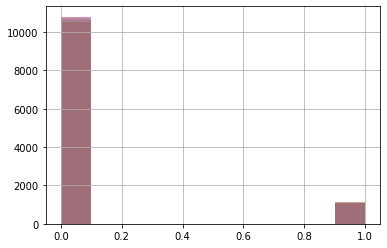

In [23]:
df_folds = pd.read_csv(f'{DATA_PATH}/upsample.csv', index_col='image_id',
                       usecols=['image_id', 'fold', 'target'], dtype={'fold': np.byte, 'target': np.byte})

_ = df_folds.groupby('fold').target.hist(alpha=0.4)
df_folds.groupby('fold').target.mean().to_frame('ratio').T

In [24]:
df_test = pd.read_csv(f'{DATA}/test.csv', index_col='image_name')

if debug:
    df_folds = df_folds.sample(batch_size * 80)

df_folds = df_folds.sample(frac=1.0, random_state=seed*6+fold_number)

In [25]:
ds_train, ds_val, ds_test = load_datasets(fold_number)

(47225, 11691, 10982)

# Model

In [26]:
from efficientnet_pytorch import EfficientNet
from pytorch_lightning.metrics.classification import AUROC
from sklearn.metrics import roc_auc_score

class Model(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()
        self.net = EfficientNet.from_pretrained(arch, advprop=True)
        self.net._fc = nn.Linear(in_features=self.net._fc.in_features, out_features=1, bias=True)

    def forward(self, x):
        return self.net(x)

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            max_lr=lr,
            epochs=max_epochs,
            optimizer=optimizer,
            steps_per_epoch=int(len(ds_train) / batch_size),
            pct_start=0.1,
            div_factor=10,
            final_div_factor=100,
            base_momentum=0.90,
            max_momentum=0.95,
        )
        return [optimizer], [scheduler]

    def step(self, batch):
        # return batch loss
        x, y  = batch
        y_hat = self(x).flatten()
        y_smo = y.float() * (1 - label_smoothing) + 0.5 * label_smoothing
        loss  = F.binary_cross_entropy_with_logits(y_hat, y_smo.type_as(y_hat),
                                                   pos_weight=torch.tensor(pos_weight))
        return loss, y, y_hat.sigmoid()

    def training_step(self, batch, batch_nb):
        # hardware agnostic training
        loss, y, y_hat = self.step(batch)
        acc = (y_hat.round() == y).float().mean().item()
        tensorboard_logs = {'train_loss': loss, 'acc': acc}
        return {'loss': loss, 'acc': acc, 'log': tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        loss, y, y_hat = self.step(batch)
        return {'val_loss': loss,
                'y': y.detach(), 'y_hat': y_hat.detach()}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        y = torch.cat([x['y'] for x in outputs])
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        auc = AUROC()(pred=y_hat, target=y) if y.float().mean() > 0 else 0.5 # skip sanity check
        acc = (y_hat.round() == y).float().mean().item()
        print(f"Epoch {self.current_epoch} acc:{acc} auc:{auc}")
        tensorboard_logs = {'val_loss': avg_loss, 'val_auc': auc, 'val_acc': acc}
        return {'avg_val_loss': avg_loss,
                'val_auc': auc, 'val_acc': acc,
                'log': tensorboard_logs}

    def test_step(self, batch, batch_nb):
        x, _ = batch
        y_hat = self(x).flatten().sigmoid()
        return {'y_hat': y_hat}

    def test_epoch_end(self, outputs):
        y_hat = torch.cat([x['y_hat'] for x in outputs])
        assert len(df_test) == len(y_hat), f"{len(df_test)} != {len(y_hat)}"
        df_test['target'] = y_hat.tolist()
        N = len(glob('submission*.csv'))
        df_test.target.to_csv(f'submission{N}.csv')
        return {'tta': N}

    def train_dataloader(self):
        return DataLoader(ds_train, batch_size=batch_size, num_workers=num_workers,
                          drop_last=True, shuffle=True, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(ds_val, batch_size=batch_size, num_workers=num_workers,
                          drop_last=False, shuffle=False, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(ds_test, batch_size=batch_size, num_workers=num_workers,
                          drop_last=False, shuffle=False, pin_memory=False)

In [29]:
checkpoint = sorted(list(SAVE_DIR.iterdir()), key=lambda x: int(x.stem.split('_')[0]))
checkpoint = str(checkpoint[-1]) if len(checkpoint) else None

In [31]:
model = Model()#.load_from_checkpoint(str(checkpoint))

Loaded pretrained weights for efficientnet-b5


In [27]:
wandb.init(project='melanoma', tags=['amp', 'lightning'], name='upsampled_full_data')
wandb_logger = WandbLogger(project='melanoma', tags=['amp', 'lightning'], name='upsampled_full_data')
wandb.watch(model)

tensor([[0, 0, 0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int8)

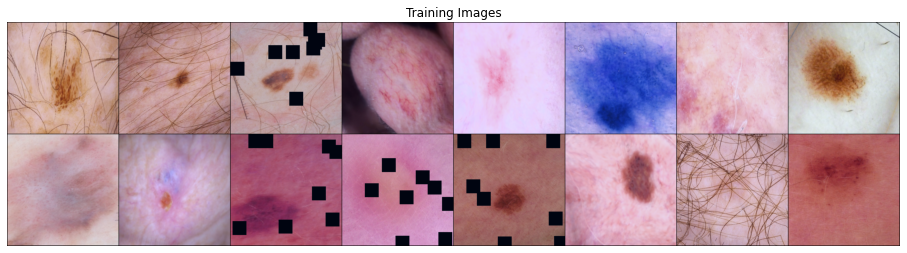

In [20]:
# Plot some training images
import torchvision.utils as vutils
batch, targets = next(iter(model.train_dataloader()))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images")
_ = plt.imshow(vutils.make_grid(
    batch[:16], nrow=8, padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0)))

targets[:16].reshape([2, 8]) if len(targets) >= 16 else targets

In [21]:
# # test the same images
# with torch.no_grad():
#     print(model(batch[:16]).reshape([len(targets)//8,8]).sigmoid())
del batch; del targets

# Train
The Trainer automates the rest.

Trains on 8 TPU cores, GPU or CPU - whatever is available.

In [33]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(filepath="f{epoch:02d}_{val_auc:.4f}",
                                                   save_top_k=1, monitor='val_auc', mode='max')
if len(checkpoints):
    trainer = pl.Trainer(resume_from_checkpoint=checkpoints[-1],
                        default_root_dir=SAVE_DIR,
                        tpu_cores=tpu_cores,
                        gpus=gpus,
                        precision=16 if gpus else 32,
                        max_epochs=max_epochs,
                        num_sanity_val_steps=1 if debug else 0,
                        checkpoint_callback=checkpoint_callback
                        logger=wandb_logger)
else:
    trainer = pl.Trainer(
        default_root_dir=SAVE_DIR,
        tpu_cores=tpu_cores,
        gpus=gpus,
        precision=16 if gpus else 32,
        max_epochs=max_epochs,
        num_sanity_val_steps=1 if debug else 0,
        checkpoint_callback=checkpoint_callback,
        logger=wandb_logger
    #     val_check_interval=0.25, # check validation 4 times per epoch
        )

NameError: name 'checkpoint_callback' is not defined

In [40]:
# clean up gpu in case you are debugging 
import gc
torch.cuda.empty_cache(); gc.collect()
torch.cuda.empty_cache(); gc.collect()

0

In [41]:
trainer.fit(model)


  | Name | Type         | Params
--------------------------------------
0 | net  | EfficientNet | 28 M  


KeyboardInterrupt: 